# Phase C

## 3.1. Read in an image and display it in RGB mode

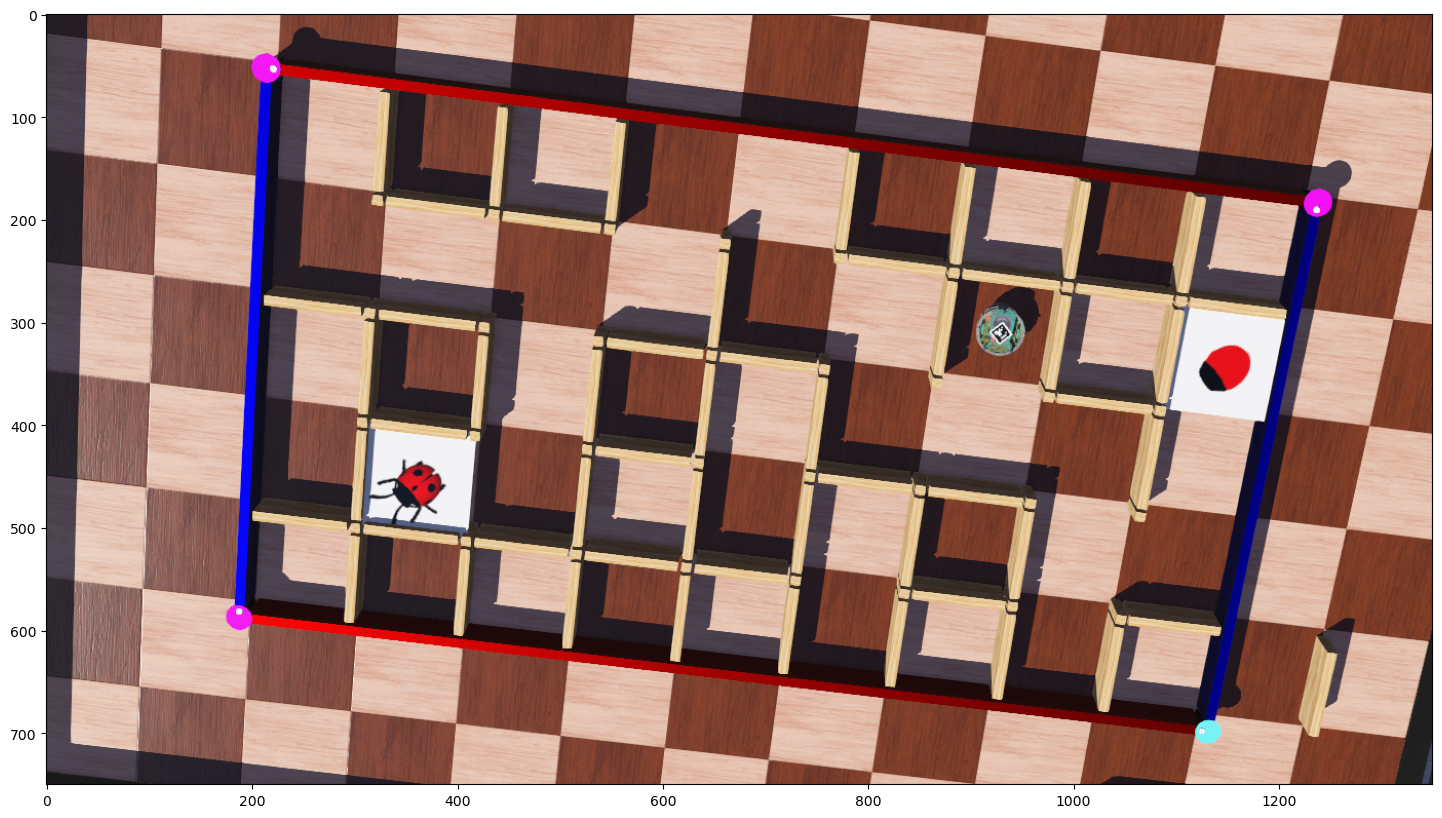

In [109]:
import cv2 # OpenCV library
import numpy as np # Numpy library for scientific computing
import matplotlib.pyplot as plt # Matplotlib library for plotting

img = cv2.imread('../PhaseCTests/Maze_4.png') #change map
robot_image = cv2.imread('../PhaseCTests/Robot_4.png') #change robot

img_rgb_maze = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV reads an image in the BGR order by default, this function can change the order to RGB
plt.figure(figsize = (18, 10))
plt.imshow(img_rgb_maze)
plt.show()

## 3.2. Find the four ordered cornerstones of the maze

1132 698
[[1132.  698.]
 [ 187.  587.]
 [1238.  183.]
 [ 213.   52.]]


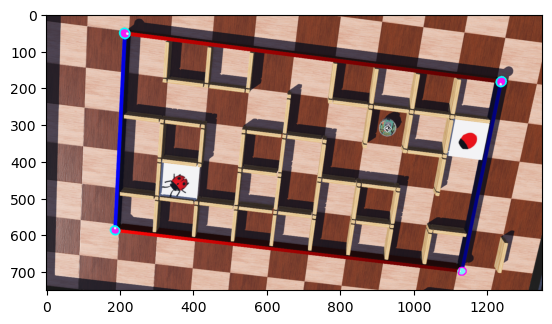

In [110]:
### Task 2 - Identify corners
corners = np.empty((0, 2), np.float32)
# Define HSV thresholds
cyanLower     = np.array([ 72, 108, 222])
cyanHigher    = np.array([103, 140, 255])
magentaLower  = np.array([136, 150, 205])
magentaHigher = np.array([157, 241, 255])

# Change image to HSV
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
kernel = np.ones((3,3), np.uint8)

# Identify Cyan marker
cyanMask = cv2.inRange(img_hsv, cyanLower, cyanHigher)
cyanMask = cv2.erode(cyanMask, kernel, iterations = 2)
cyanMask = cv2.dilate(cyanMask, kernel, iterations = 10)
cyanMask = cv2.erode(cyanMask, kernel, iterations = 8)
cyanMask = cv2.morphologyEx(cyanMask, cv2.MORPH_CLOSE, kernel)

# Get centre of Cyan Marker and mark with a magenta circle
_, contours, _ = cv2.findContours(cyanMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
m = cv2.moments(contours[0]) 

cx = int(m['m10']/m['m00'])
cy = int(m['m01']/m['m00'])
if cx >= 1012 and cy >= 375:
    cyan_position = 'D'
else:
    cyan_position = 'A'

cv2.drawContours(img_rgb_maze, contours, -1, (255,0,255), 2)
corners = np.append(corners, [[cx, cy]], axis = 0)
print(cx,cy)
# Identify Magenta markers
magentaMask = cv2.inRange(img_hsv, magentaLower, magentaHigher)
magentaMask = cv2.dilate(magentaMask, kernel, iterations = 5)
magentaMask = cv2.erode(magentaMask, kernel, iterations = 5)
magentaMask = cv2.morphologyEx(magentaMask, cv2.MORPH_CLOSE, kernel)

# Get centre of Magneta Markers and mark with a cyan circle
_, contours, _ = cv2.findContours(magentaMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
for con in contours:
    m = cv2.moments(con) 
    cx = int(m['m10']/m['m00'])
    cy = int(m['m01']/m['m00'])
    corners = np.append(corners, [[cx, cy]], axis = 0)

cv2.drawContours(img_rgb_maze, contours, -1, (0,255,255), 3)
i = 0
while i < 4:
    if corners[i][0] >= 1012 and corners[i][1] >= 375:
        coordX_D = corners[i][0]
        coordY_D = corners[i][1]
    elif corners[i][0] <= 338 and corners[i][1] >= 375:
        coordX_C = corners[i][0]
        coordY_C = corners[i][1]
    elif corners[i][0] >= 1012 and corners[i][1] <= 375:
        coordX_B = corners[i][0]
        coordY_B = corners[i][1]
    elif corners[i][0] <= 338 and corners[i][1] <= 375:
        coordX_A = corners[i][0]
        coordY_A = corners[i][1]
    i = i + 1

print(corners)
plt.imshow(img_rgb_maze)
plt.show()

## 3.3. Perspective transform the maze from the original image to a rectangle image


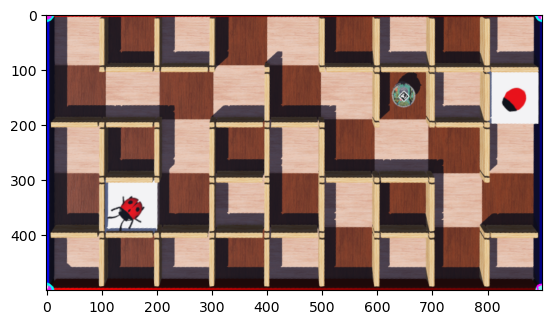

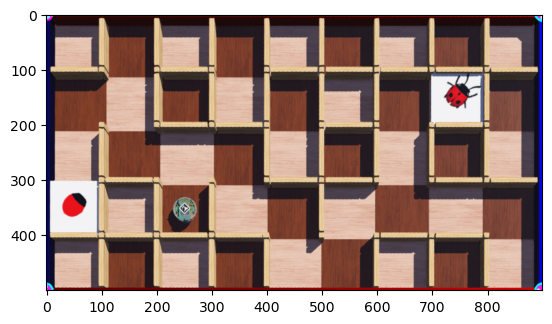

In [111]:
# Perspective tranformation
#pts1 = np.float32([[corners[3][0],corners[3][1]],[corners[2][0],corners[2][1]],[corners[1][0],corners[1][1]],[corners[0][0],corners[0][1]]]) # four points on the first image
pts1 = np.float32([[coordX_A,coordY_A],[coordX_B,coordY_B],[coordX_C,coordY_C],[coordX_D,coordY_D]])
pts2 = np.float32([[0,0],[900,0],[0,500],[900,500]]) # four points on the second image

H = cv2.getPerspectiveTransform(pts1,pts2) # homography matrix

dst = cv2.warpPerspective(img_rgb_maze, H, (900,500))
plt.imshow(dst)
plt.show()
transformed = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
cv2.imwrite("../Transformed_Maze.png", transformed)
cv2.imwrite("../Robot_rotated.png", robot_image)

if cyan_position == 'D':
    center = (450,250)
    M = cv2.getRotationMatrix2D(center, 180, 1.0)
    rotated180 = cv2.warpAffine(dst, M, (900, 500))
    plt.imshow(rotated180)
    plt.show()
    transformed = cv2.cvtColor(rotated180, cv2.COLOR_BGR2RGB)
    cv2.imwrite("../Transformed_Maze.png", transformed)
    
    center = (375,375)
    M = cv2.getRotationMatrix2D(center, 180, 1.0)
    rotated180_robot = cv2.warpAffine(robot_image, M, (750, 750))
    cv2.imwrite("../Robot_rotated.png", rotated180_robot)

## 3.4. Detect all the internal walls

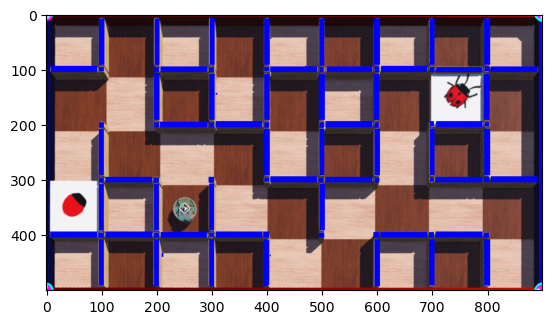

In [112]:
img = cv2.imread('../Transformed_Maze.png')
img_gray = cv2.imread('../Transformed_Maze.png',cv2.IMREAD_GRAYSCALE)
img_rgb_maze = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV reads an image in the BGR order by default, this function can change the order to RGB
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

##walls masking
Wall = cv2.inRange(img_hsv, (13,57,226), (20,112,236))
Wall_mask = Wall > 0
walls_find = np.zeros_like(img, np.uint8)
walls_find[Wall_mask] = img[Wall_mask]
cv2.imwrite("../walls.png", walls_find)
img_walls = cv2.imread('../walls.png')
img_rgb_walls = cv2.cvtColor(img_walls, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_rgb_walls, cv2.COLOR_BGR2RGB)

#coords
black = (0,0,0)
X,Y = np.where(np.all(walls_find!=black, axis=2))


#edges
edges = cv2.Canny(img_gray, threshold1 = 300, threshold2 = 100, apertureSize = 3)
img2, contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

Num_Walls = len(contours)
Num_Points = 0
Walls = np.arange(Num_Walls*4).reshape((Num_Walls, 4))

j = 0
while j < Num_Walls:
    Num_Points = (np.rint((contours[j].size)/2)).astype(int)
    Y_wall = np.arange(Num_Points)
    X_wall = np.arange(Num_Points)
    i=0
    while i < Num_Points:
        Y_wall[i] = contours[j][i][0][0]
        X_wall[i] = contours[j][i][0][1]
        i=i+1
        
    Walls[j][0] = np.amin(X_wall)
    Walls[j][1] = np.amin(Y_wall)
    Walls[j][2] = np.amax(X_wall)
    Walls[j][3] = np.amax(Y_wall)
    
    central_x_start = ((np.rint((Walls[j][2]-Walls[j][0])/2)) + Walls[j][0]).astype(int)
    central_x_end = ((np.rint((Walls[j][2]-Walls[j][0])/2)) + Walls[j][2]).astype(int)
    central_y_start = ((np.rint((Walls[j][3]-Walls[j][1])/2)) + Walls[j][1]).astype(int)
    central_y_end = ((np.rint((Walls[j][3]-Walls[j][1])/2)) + Walls[j][3]).astype(int)
                   
    cv2.rectangle(img_rgb,(Walls[j][1],Walls[j][0]),(Walls[j][3],Walls[j][2]),(0, 0, 255),-1) 
                   
    j = j+1


#plot the image
plt.imshow(img_rgb)
plt.show()

## 3.5. Detect the location and heading of the robot

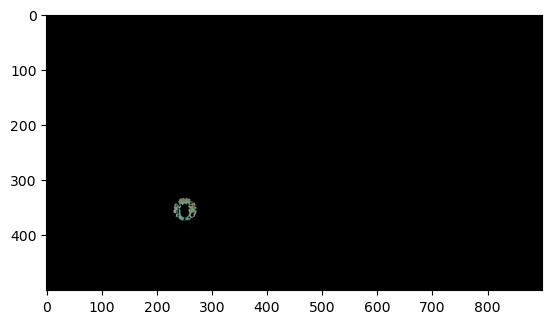

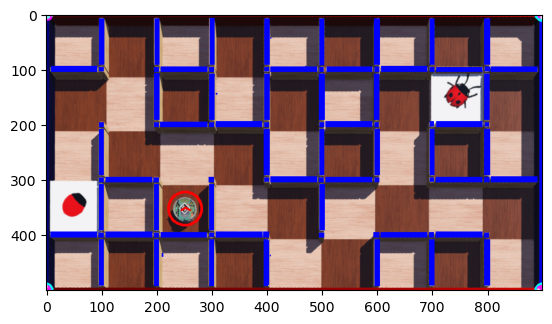

In [113]:
Robot = cv2.inRange(img_hsv, (21,0,0), (89,177,255))
robot_mask = Robot > 0
robot_find = np.zeros_like(img, np.uint8)
robot_find[robot_mask] = img[robot_mask]
img_rgb_robot = cv2.cvtColor(robot_find, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_rgb_robot, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb_robot)
plt.show()

black = (0,0,0)
Y,X = np.where(np.all(robot_find!=black, axis=2))
size_x = len(X)-1
size_y = len(Y)-1
#radius = (((np.ptp(X[12:size_x-10]) + np.ptp(Y[1:size_y-1]))/2)/2).astype(int)
radius = 30
coordY = (np.rint(np.mean(Y[10:size_y-10]))).astype(int)
coordX = (np.rint(np.mean(X[10:size_x-10]))).astype(int)
#print(radius,coordY,coordX)

cv2.circle(img_rgb, (coordX,coordY), 30, (255,0,0), 4, lineType=cv2.FILLED, shift=0)


arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_50)
arucoParams = cv2.aruco.DetectorParameters_create()
image = cv2.imread('../Robot_rotated.png')
(corners, ids, rejected) = cv2.aruco.detectMarkers(image, arucoDict,parameters=arucoParams)

i = 0
#for all i in corners[0][0][i]:
if ((corners[0][0][i][0] <  corners[0][0][i+1][0]) and (corners[0][0][i][0] < corners[0][0][i+2][0]) and (corners[0][0][i][0] < corners[0][0][i+3][0])):
    Direction = '<'
elif ((corners[0][0][i][0] >  corners[0][0][i+1][0]) and (corners[0][0][i][0] > corners[0][0][i+2][0]) and (corners[0][0][i][0] > corners[0][0][i+3][0])):
    Direction = '>'
elif ((corners[0][0][i][1] <  corners[0][0][i+1][1]) and (corners[0][0][i][1] < corners[0][0][i+2][1]) and (corners[0][0][i][1] < corners[0][0][i+3][1])):
    Direction = '^'
elif ((corners[0][0][i][1] >  corners[0][0][i+1][1]) and (corners[0][0][i][1] > corners[0][0][i+2][1]) and (corners[0][0][i][1] > corners[0][0][i+3][1])):
    Direction = 'v'

    
font = cv2.FONT_HERSHEY_SIMPLEX    
cv2.putText(img_rgb,Direction,(coordX-10,coordY+10), font, 1,(255,0,0),2,cv2.LINE_AA)    
plt.imshow(img_rgb)
plt.show()

## 3.6. Detect the position of the true target

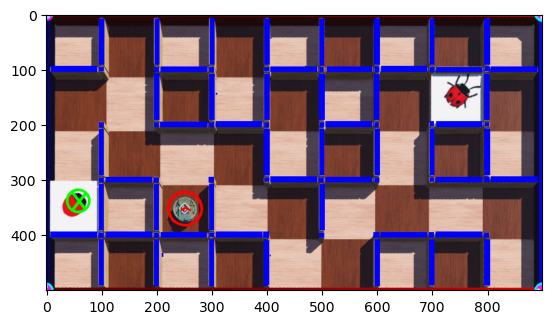

In [114]:
img_gray = img_rgb
template = cv2.imread('../Ladybug_small1.png')
template_gray = cv2.cvtColor(template,cv2.COLOR_BGR2RGB) 

w = 69
h = 69
method = 'cv2.TM_CCOEFF_NORMED'

#apply method
method = eval(method)

res = cv2.matchTemplate(img_gray,template_gray,method)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)

coord_x = (np.rint((bottom_right[0] - top_left[0])/2 + top_left[0])).astype(int)
coord_y = (np.rint((bottom_right[1] - top_left[1])/2 + top_left[1])).astype(int)
radius_target = 20

cv2.circle (img_gray, (coord_x,coord_y), radius_target, (0,255,0), 3, lineType=cv2.FILLED, shift=0)
cv2.putText(img_gray,'x',(coord_x-15,coord_y+15), font, 2,(0,255,0),3,cv2.LINE_AA)  


plt.imshow(img_gray, cmap='gray')
plt.show()

## 3.7. Generate a map and write it to a text file


In [115]:
outfile = open('../MapBuilt.txt', "w")
line_num = 1
outfile.write(" --- --- --- --- --- --- --- --- --- ")
outfile.write("\n")

loc_x = 50
loc_y = 100
loc_x_horizontal = 100
loc_y_horizontal = 50

wall = 'no'
Hwall = 'no'
col = 0
row = 0
col_horizontal = 0
Num_Walls = len(contours) -1
i = Num_Walls
j = Num_Walls

while(row < 5):
    outfile.write("|")
    #outfile.write("   ") 
    
    while(col < 9):
        if (coord_x < loc_y and coord_x > loc_y-100 and coord_y > (loc_x-50) and coord_y < (loc_x+50)):
            outfile.write(" x ")
        elif(coordX < loc_y and coordX > loc_y-100 and coordY > (loc_x-50) and coordY < (loc_x+50)):
            outfile.write(" ")
            outfile.write(Direction)
            outfile.write(" ")
        else:
            outfile.write("   ")
        i = Num_Walls
        if (col == 8):
            outfile.write("|")
            break
        
        while (i >= 0):
            #print(Walls[i])
            if (Walls[i][0] < loc_x and Walls[i][2] > loc_x and Walls[i][1] < loc_y and Walls[i][3] > loc_y):
                outfile.write("|")
                wall = 'yes'
                break
            else: 
                i = i-1
                wall = 'no'
                
        if (wall == 'no' and col != 8):
            outfile.write(" ")    
        col = col + 1
        loc_y = loc_y + 100
        
    outfile.write("\n")
    if(row < 4):
        #outfile.write(" ")
        while(col_horizontal < 9):
            outfile.write(" ")
            j = Num_Walls
            while (j >= 0):
                if (Walls[j][0] < loc_x_horizontal and Walls[j][2] > loc_x_horizontal and Walls[j][1] < loc_y_horizontal and Walls[j][3] > loc_y_horizontal):
                    outfile.write("---")
                    Hwall = 'yes'
                    break
                else: 
                    j = j-1
                    Hwall = 'no'


            if (Hwall == 'no'):
                outfile.write("   ")    
            col_horizontal = col_horizontal + 1
            loc_y_horizontal = loc_y_horizontal + 100
        
        outfile.write(" ")  
    
    
    loc_y_horizontal = 50
    loc_x_horizontal = loc_x_horizontal + 100
    loc_y = 100
    loc_x = loc_x + 100
    col_horizontal = 0
    col = 0
    row = row+1
    if(row < 5):    
        outfile.write("\n")

outfile.write(" --- --- --- --- --- --- --- --- --- ")
outfile.close()